## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transformations

## Create a Bidirectional Lstm Network 

In [2]:
class BLSTM(nn.Module):
    def __init__(self, imp_emb_dim, hidden_units, n_layers, output_classes):
        super(BLSTM, self).__init__()

        self.n_layers = n_layers
        self.hidden_units = hidden_units

        self.bilstm = nn.LSTM(input_size=imp_emb_dim,
                               hidden_size=hidden_units,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=True)
        
        self.fc = nn.Linear(hidden_units*imp_emb_dim*2, output_classes)

    def forward(self, x):

        # Initialize the hidden state and cell state first for bidrectional lstm
        h0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_units).to(device)
        c0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_units).to(device)
        
        # Forward Propagation
        out, _ = self.bilstm(x, (h0, c0))
        out_flatten = torch.flatten(out, 1,-1)
        x = self.fc(out_flatten)

        return x


In [3]:
# check the network graph
model = BLSTM(28, 5, 10, 10)

# create a random variable and pass it to the model to check the network graph
device = 'cpu'
x = torch.randn(64, 28, 28)
h0 = torch.zeros(10*2, x.size(0), 5).to(device)
c0 = torch.zeros(10*2, x.size(0), 5).to(device)


print(x.shape)
print(model(x).shape)

torch.Size([64, 28, 28])
torch.Size([64, 10])


In [4]:
# Undersatnding RNN layer
n_layer = 10
hidden_size = 5
emb_dim = 28
batch_size = 64
max_seq_length = 12

In [5]:
lstm_cell = nn.LSTM(input_size=emb_dim,
                               hidden_size=hidden_size,
                               num_layers=n_layer,
                               batch_first=True,
                               bidirectional=True)

In [6]:

# create a random variable and pass it to the model to check the network graph
x = torch.randn(batch_size, max_seq_length, emb_dim)
print(x.shape)

hidden_state = torch.zeros(n_layer*2, batch_size, hidden_size)
cell_state = torch.zeros(n_layer*2, batch_size, hidden_size)
print(hidden_state.shape)
print(cell_state.shape)

torch.Size([64, 12, 28])
torch.Size([20, 64, 5])
torch.Size([20, 64, 5])


In [7]:
lstm_cell_output = lstm_cell(x, (hidden_state, cell_state))

In [8]:
# batch_first=True
len(lstm_cell_output)

2

In [9]:
lstm_cell_output[0].shape

torch.Size([64, 12, 10])

In [10]:
# Hidden gate output , cell gate output
lstm_cell_output[1][0].shape, lstm_cell_output[1][1].shape

(torch.Size([20, 64, 5]), torch.Size([20, 64, 5]))

## Set device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## HyperParameters

In [12]:
n_class = 10
n_layer = 10
hidden_size = 5
emb_dim = 28
batch_size = 64
max_seq_length = 12
learning_rate = 0.001
num_epochs = 9
load_model = True

## Load Data

In [13]:
# download and load the data from pytorch sample datasets
# https://pytorch.org/vision/0.8/datasets.html

train_dataset = datasets.MNIST(
    root="../dataset/", train=True, transform=transformations.ToTensor(), download=True
)
train_datloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


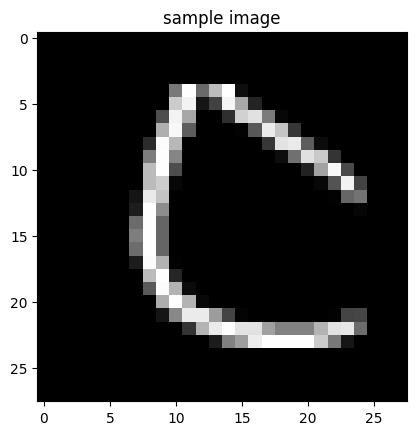

Label: 0


In [14]:
import matplotlib.pyplot as plt

# Understand the dataloader
plt.title("sample image")
# Display image and label.
train_features, train_labels = next(iter(train_datloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
# train data shape and class labels
print("train_dataset shape:", train_dataset.data.shape)
print(train_dataset.classes)

train_dataset shape: torch.Size([60000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [16]:
test_dataset = datasets.MNIST(
    root="../dataset/", train=False, transform=transformations.ToTensor(), download=True
)
test_datloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("test_dataset shape:", test_dataset.data.shape)
print(test_dataset.classes)

test_dataset shape: torch.Size([10000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## Initialise Network


In [17]:
model = BLSTM(emb_dim, hidden_size, n_layer, n_class)
print(model)

BLSTM(
  (bilstm): LSTM(28, 5, num_layers=10, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=10, bias=True)
)


## Initialise Loss And Optimizer

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Checkpoints

In [19]:
def save_checkpoint(checkpoint, filename='../checkpoint.pth.tar'):
    print('==> saving checkpoint')
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint):
    print('==> loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

## Train Network

#### Steps to train the model
1. For each epoch, iterate through the batch
2. For each batch
    * feed forward the input and target data of train to the model
    * Calculate the loss and score
    * Backpropogate the loss
    * optimise the loss using optimiser() (gradient descent is one such optimiser) 


In [22]:
%%time

def train(model):
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate((train_datloader)):



            # get data to cuda if possible
            data = data.to(device)
            # Squeeze the dim of data from (B X 1 X 28 X 28) to (B X 28 X 28)
            data = data.squeeze(dim=1)
            target = target.to(device)

            # feed forward the data to model
            scores = model(data)
            loss = criterion(scores, target)
            # print(f"epoch: {epoch}, batch: {batch_idx}, loss: {loss}")
            
            # Backpropagation
            optimizer.zero_grad() # This will flush the gradients from the last iteration
            loss.backward()

            # optimise the loss (gradient descent or Adam step)
            optimizer.step()

        # Create a model checkpoint
        if epoch % 3 == 0:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint)
            print(f"epoch: {epoch}, batch: {batch_idx}, loss: {loss}")

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
# get model to cuda if possible
model = model.to(device)

# Train the model
train(model)

==> saving checkpoint
epoch: 0, batch: 937, loss: 0.5602800250053406
==> saving checkpoint
epoch: 3, batch: 937, loss: 0.059763237833976746
==> saving checkpoint
epoch: 6, batch: 937, loss: 0.12418629229068756


In [24]:
if load_model:
    load_checkpoint(torch.load('../checkpoint.pth.tar'))

==> loading checkpoint


## Check accuracy on train and test data (Validate model accuracy)

In [25]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model

    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:
            # Move data to device
            x = x.to(device=device)
            # Squeeze the dim of x from (B X 1 X 28 X 28) to (B X 28 X 28)
            x = x.squeeze(dim=1)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            predictions = scores.argmax(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [26]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_datloader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_datloader, model)*100:.2f}")

Accuracy on training set: 96.74
Accuracy on test set: 96.56
